In [1]:
import numpy as np
from math import *
import scipy as scp
from scipy import fftpack as fft
from scipy import io, integrate

from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from matplotlib import animation,cm,rc
from mpl_toolkits.mplot3d import Axes3D

from time import time as ctime
import os,glob,subprocess
import warnings; warnings.simplefilter('ignore')


##########
from IPython.display import display,HTML,Image
display(HTML("<style>.container { width:90% !important; }</style>"))

##########
rc('legend', frameon=False,fancybox=True,shadow=True,fontsize=14,loc='best')
rc('lines', linewidth=2)
font = {'family':'serif','size':30}
rc('font',**font)
rc('text', usetex=True)
rc('xtick',labelsize='larger')
rc('ytick',labelsize='larger')
rc('savefig',format='pdf')
rcParams.update({'figure.autolayout': True})
rc('figure',figsize= [10.0, 10.0])
figheight=6

In [2]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Spontaneous Kelvin Helmoltz

Data for the  figures of the short paper

#### Data Set
It is composed of 3 series of runs


| Label  | Dissipation | Resolutions| Initial State|
|------|------|------|---------------|
|9S|$\nabla^2$|$$512,1024,2048,8192,16384$$|$$\omega(x,y) = \omega_0 \delta(x)\delta(y-y(x)) $$ $$y(x) \sim \epsilon N(0,1) iid$$|
|9H|$\nabla^8$|$$512,2048,8192$$|$$\omega(x,y) = \omega_0 \delta(x)\delta(y-y(x)) $$ $$y(x) \sim \epsilon N(0,1) iid$$|
|10H|$\nabla^8$|$$512,2048,8192$$|$$\omega = \omega_0 (1+\epsilon^2) \delta(x)$$|

The data are contained in the archives named as :

##### Label-Resolution-MixingLayer.npz
    (ex:9H-512-MixingLayer.npz)
    with fields
  
| Field Name | Shape | Description |Comment|
|-| - | - |-|
|n| $$1$$  | resolution||  
|timebin|  $$Nbin$$  | Output times for fields| t=0  when  non-linear evolution is triggered|  
|x|  $$ n$$ |Space coordinate| |  
|av|  $$n \times Nbin$$ |$$<\bar w >(y)$$|$$ \text{Ensemble average of}$$  $$  \bar w(y) := \dfrac{1}{2\pi} \int_{-\pi}^{\pi} w dx $$|   
|counts| $$Nbin$$  | Number of Realizations used for the ensemble average| Not all simulations have same output frequencies: Average may depend on the times considered|  
|x4|  $$n/4$$ |distance $\Delta$ from initial shear layer| |  
|av4|  $$n/4\times Nbin$$ | $$<\bar w>(\Delta)$$ || $$\text{Average of}$$  $$\pm <\bar{w}(y)>$$ $$\text{with respect to distance to initial singularity}$$| |  



##### Label-Resolution-Spectra.npz
    (ex:9H-512-Spectra.npz)
    with fields
| Field Name | Shape | Description |Comment|
|-| - | - |-|
|k|  $$n$$  |  Wavenumbers||  
|timespec|  $$Nspec$$  | Output times for spectra| t=0  when  non-linear evolution is triggered|  
|Pek|  $$3\times n\times Nspec$$  | Energy fluxes| first dimension  partitions Fourier Space into 3 equi-angular sectors|  
|ek|  $$3\times n\times Nspec$$|Energy spectra for spectra|  0: perpendicular, 1: Intermediate, 2: Parallel  

### FIGURES 0 : Visuals

The videos below display the magnitude of vorticity for 

9S $n = 8192$ ; 9H $n = 8192$; 

9H $n = 2048$ ; 10H $n = 8192$ 


Upper halves have logarithmic color scales while  lower halves have linear color scales.

In [3]:
HTML("""<table><tr>\
            <td><video width="70%" controls><source src="DATA_KH/Videos/9S-8192.mp4" type="video/mp4"></video></td>\
            <td><video width="70%" controls><source src="DATA_KH/Videos/9H-8192.mp4" type="video/mp4"></video></td>\
            </tr></table>
            <table><tr>\
            <td><video width="70%" controls><source src="DATA_KH/Videos/10H-8192.mp4" type="video/mp4"></video></td>\
            <td><video width="70%" controls><source src="DATA_KH/Videos/9H-2048.mp4" type="video/mp4"></video></td>\
            </tr></table>
            """)

,
,


We now consider as a specific example the serie '10H'

In [4]:
LabelSerie='10H'
ListOfResos=[512,2048,8192]

### FIGURE 1 : Initial scaling

<IPython.core.display.Javascript object>


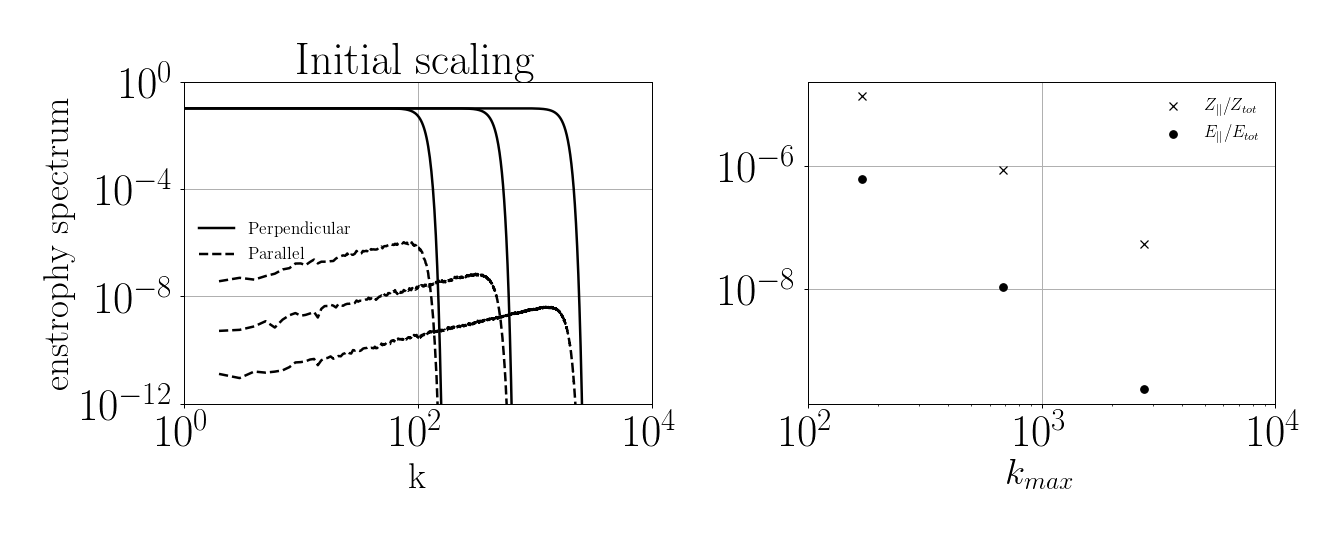

In [5]:
%matplotlib notebook
fig,axs=subplots(1,2,figsize=(2.5*figheight,figheight),num='enstrophy scaling')
        
for n in ListOfResos:
    File='DATA_KH/%s-%d-Spectra.npz' %(LabelSerie,n)
    with np.load(File) as data:
        k,Pek,ek,timespec=data['k'],data['Pek'],data['ek'],data['timespec']
    
    eperp=ek[0,:,:]
    epar=ek[2,:,:]
    etot_0=ek[:,:,0].sum()
    ztot_0=(k**2*(ek[:,:,0].sum(axis=0))).sum()
    epar_0=epar[:,0].sum()
    zpar_0=(k**2*epar[:,0]).sum()
    
    if n==512:
        label1='Perpendicular'
        label2='Parallel'
    else:
        label1=None
        label2=None

    ax=axs[0]
    a=2
    ax.plot(k[::2],k[::2]**a*eperp[::2,0],'k-',label=label1)
    ax.plot(k[1::1],k[1::1]**a*epar[1::1,0],'k--',label=label2)
    
    if n==512:
        label1='$E_\parallel/E_{tot}$'
        label2='$Z_\parallel/Z_{tot}$'
    else:
        label1=None
        label2=None

    ax=axs[1]
    ax.plot(n//3,zpar_0/ztot_0,'kx',label=label2)
    ax.plot(n//3,epar_0/etot_0,'ko',label=label1)
    
ax=axs[0]    
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.legend()
ax.set_xlim(1,1e4)
ax.set_ylim(1e-12,1e0)

ax.set_xlabel('k')
ax.set_ylabel('enstrophy spectrum')
ax.set_title('Initial scaling')

ax=axs[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid()
ax.set_xlabel('$k_{max}$')
ax.set_xlim(1e2,1e4)
#ax.set_ylim(1e-6,1e-4)

fig.tight_layout()
show()


### FIGURE 2 : Evolution of the vorticity correlation and Front propagation 
(Slightly steeper than linear?)

<IPython.core.display.Javascript object>


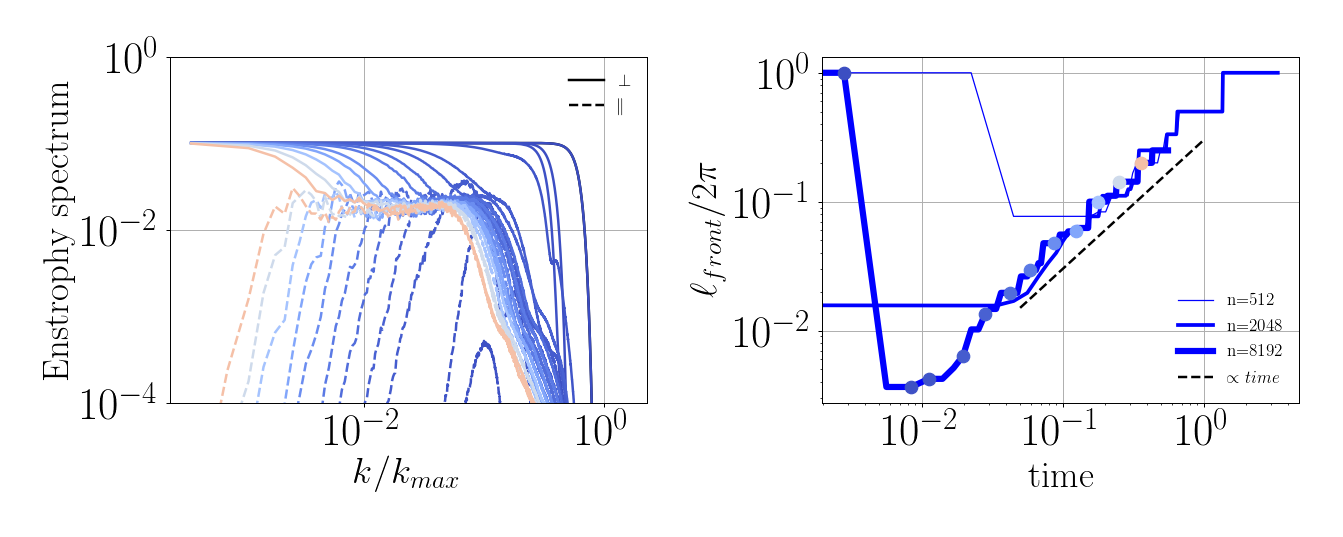

In [6]:
fig,axs=subplots(1,2,figsize=(2.5*figheight,figheight),num='Correlations')
def logrange(timespec):
    a=2**(0.5)
    nspec=len(timespec)
    logmax=np.floor(np.log(nspec)/np.log(a))
    return np.unique((a**np.arange(logmax)).astype(int))-1

for n in [512,2048,8192]:
    File='DATA_KH/%s-%d-Spectra.npz' %(LabelSerie,n)
    with np.load(File) as data:
        k,Pek,ek,timespec=data['k'],data['Pek'],data['ek'],data['timespec']

    eperp=ek[0,:,:]
    epar=ek[2,:,:]
    etot=ek[:,:,0].sum()

    kmax=n//3
    tL=2*pi/np.sqrt(etot) ## Integral time

    Kfront=np.zeros_like(timespec)
    for num in range(len(timespec)):
            Kfront[num]=k[(k**0*epar[:,num]).argmax()]

    axs[1].plot(timespec/tL,1/Kfront,'b-',linewidth=np.log(n//512)/np.log(2)+1,label='n=%d' %(n,))

    cool=cm.coolwarm(np.linspace(0,1,len(timespec)))
    for num in logrange(timespec):
        if num==logrange(timespec)[0]  and n==8192:
            axs[0].plot(k[::2]/kmax,k[::2]**2*eperp[::2,num],'k',label='$\perp$')
            axs[0].plot(k/kmax,k**2*epar[::,num],'k--',label='$\parallel$')


        if n==8192:
            axs[0].plot(k[::2]/kmax,k[::2]**2*eperp[::2,num],color=cool[num,:])
            axs[0].plot(k/kmax,k**2*epar[::,num],'k--',color=cool[num,:])
            axs[1].plot(timespec[num]/tL,1/k[(k**0*epar[:,num]).argmax()],'o',markersize=10,color=cool[num,:])
        

ax=axs[0]
ax.legend()
ax.set_ylim(1e-4,1e0)
ax.set_ylabel('Enstrophy spectrum')
ax.set_xlabel('$k/k_{max}$')

ax=axs[1]
ax.set_xlabel('time')
ax.set_ylabel('$\ell_{front}/2\pi$')

tt=np.array([5e-2,1e-1,1])
axs[1].plot(tt,0.3*tt**1,'k--',label='$\propto  time$' )

#ax.set_ylim(1e-10,1e0)

for ax in axs:    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()
    ax.legend()
#    ax.set_xlim(1,1e4)


### FIGURE 3 : Mixing Layer

<IPython.core.display.Javascript object>


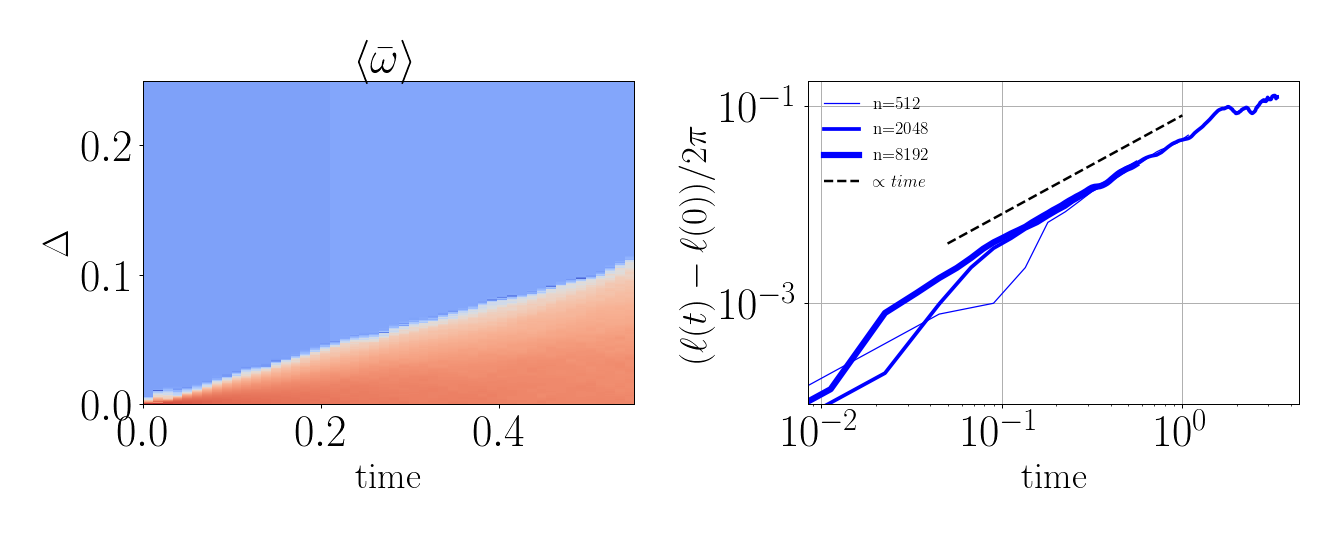

In [7]:
fig,axs=subplots(1,2,figsize=(2.5*figheight,figheight),num='Mixing Layer')
for n in [512,2048,8192]:
    #Load Files
    File='DATA_KH/%s-%d-Spectra.npz' %(LabelSerie,n)
    with np.load(File) as data:
        k,Pek,ek,timespec=data['k'],data['Pek'],data['ek'],data['timespec']

    etot=ek[:,:,0].sum()
    kmax=n//3
    tL=2*pi/np.sqrt(etot) ## Integral time

    File='DATA_KH/%s-%d-MixingLayer.npz' %(LabelSerie,n)
    with np.load(File) as data:
        counts, timebin, x, av, x4, av4=data['counts'],data['timebin'],data['x'],data['av'],data['x4'],data['av4']

    #Compute a Mixing Length from <\bar w>
    Lmix=np.zeros(len(timebin))
    for num in range(len(timebin)):
        if counts[num]>0.5:
            Lmix[num]=(x4*av4[:,num]).sum()/av4[:,num].sum()
    axs[1].plot(timebin[counts>0.5]/tL,(Lmix[counts>0.5]-Lmix[counts>0.5][0])/(2*pi),'b-',linewidth=np.log(n//512)/np.log(2)+1,label='n=%d' %(n,))

    if n==8192:
        ax=axs[0]
        ax.pcolorfast(timebin[counts>0]/tL,x4/(2*pi),np.log(np.abs(av4[:,counts>0])),cmap=cm.coolwarm)

ax=axs[1]
tt=np.array([5e-2,1e-1,1])
ax.plot(tt,0.08*tt**1,'k--',label='$\propto  time$' )
ax.set_ylabel('$(\ell(t)-\ell(0))/2\pi$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('$(\ell(t)-\ell(0))/2\pi$')

ax=axs[0]
ax.set_xlabel('time')
ax.set_ylabel('$\Delta$')
ax.set_title('$ \langle \\bar \\omega \\rangle $')
fig.tight_layout()
